In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('BestBooksDS.csv', index_col=0)

In [3]:
df.head()

,bookId,title,author,rating,language,genres,bookFormat,pages,publishDate,firstPublishDate,numRatings,likedPercent,price,publishDecade,weightedRating
0,2767052-the-hunger-games,The Hunger Games,Suzanne Collins,4.33,English,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",hardcover,374,2008-09-14,NaN,6376780,96.0,5.09,2000,4.329518
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,English,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",paperback,870,2004-09-28,2003-06-21,2507623,98.0,7.38,2000,4.498101
2,2657.To_Kill_a_Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,English,"['Classics', 'Fiction', 'Historical Fiction', ...",paperback,324,2006-05-23,2060-07-11,4501075,95.0,5.62,2000,4.279428
3,1885.Pride_and_Prejudice,Pride and Prejudice,"Jane Austen, Anna Quindlen (Introduction)",4.26,English,"['Classics', 'Fiction', 'Romance', 'Historical...",paperback,279,2000-10-10,2013-01-28,2998241,94.0,3.86,2000,4.259208
4,41865.Twilight,Twilight,Stephenie Meyer,3.60,English,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...",paperback,501,2006-09-06,2005-10-05,4964519,78.0,2.10,2000,3.600848


---

## EDA


- tamaño del dataset
- popularidad
    - autores
    - generos
    - publish decade

In [13]:
# Veo el tamaño del dataframe y el formato de las columnas

print(f'El DataFrame contiene {df.shape[0]} filas y {df.shape[1]} columnas')

El DataFrame contiene 52429 filas y 15 columnas


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52429 entries, 0 to 52477
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            52429 non-null  object 
 1   title             52429 non-null  object 
 2   author            52429 non-null  object 
 3   rating            52429 non-null  float64
 4   language          52429 non-null  object 
 5   genres            52429 non-null  object 
 6   bookFormat        52429 non-null  object 
 7   pages             52429 non-null  int64  
 8   publishDate       50645 non-null  object 
 9   firstPublishDate  31109 non-null  object 
 10  numRatings        52429 non-null  int64  
 11  likedPercent      52429 non-null  float64
 12  price             52429 non-null  float64
 13  publishDecade     52429 non-null  int64  
 14  weightedRating    52429 non-null  float64
dtypes: float64(4), int64(3), object(8)
memory usage: 6.4+ MB


#### Exploro las variables que seran utilizadas en el modelo
##### Autores ('author')

In [5]:
# Variable autores
# Veo la cantidad de autores
autores = df['author'].value_counts()

print(f'Hay un total de {len(autores)} autores')

Hay un total de 28227 autores


In [8]:
# Veo los autores con mas libros publicados

print(autores[:10])

Nora Roberts (Goodreads Author)       86
Agatha Christie                       72
Stephen King (Goodreads Author)       66
Erin Hunter                           59
Bella Forrest (Goodreads Author)      53
Meg Cabot (Goodreads Author)          52
Lucian Bane (Goodreads Author)        49
Terry Pratchett                       48
Karen Kingsbury (Goodreads Author)    48
Bonnie Bryant                         47
Name: author, dtype: int64


C:\Users\Nicolas\AppData\Local\Temp\ipykernel_11076\3717570273.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  autores_populares = df.groupby('author').sum().nlargest(5, columns='numRatings')


([0, 1, 2, 3, 4],
 [Text(0, 0, 'J.K. Rowling, Mary GrandPré (Illustrator)'),
  Text(1, 0, 'Suzanne Collins'),
  Text(2, 0, 'Stephenie Meyer'),
  Text(3, 0, 'Stephen King (Goodreads Author)'),
  Text(4, 0, 'Rick Riordan (Goodreads Author)')])

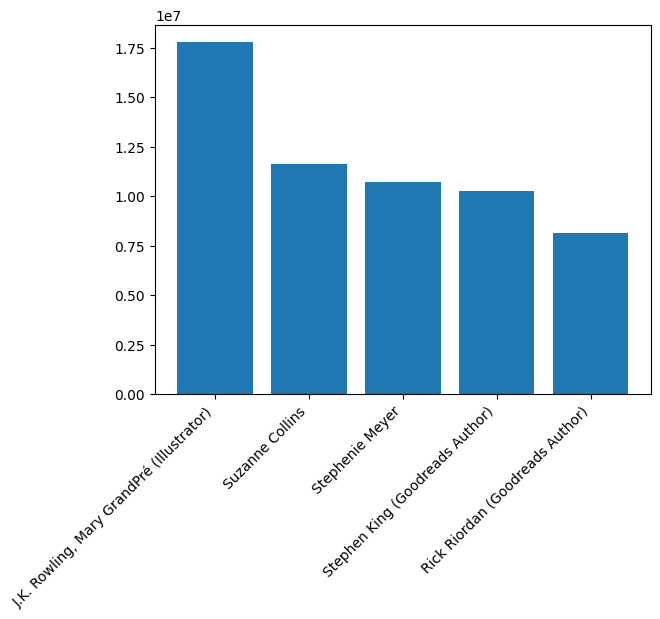

In [9]:
# Veo la cantidad de calificaciones que tienen los 5 autores mas populares

autores_populares = df.groupby('author').sum().nlargest(5, columns='numRatings')

plt.bar(x=autores_populares.index, height=autores_populares['numRatings'])
plt.xticks(rotation=45, ha='right')

##### Generos ('genres')

In [11]:
import ast
import itertools

#Concateno todas las listas de generos para poder ver cuales son los generos mas populares
genres = list()
for i in range(len(df)):

    lista = ast.literal_eval(df.iloc[i]['genres'])
    genres.append(lista)

genres = pd.Series(itertools.chain.from_iterable(genres))

In [12]:
generos_populares = genres.value_counts()[:5]

print(f'Hay un total de {len(genres.value_counts())} generos')

Hay un total de 982 generos


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Fiction'),
  Text(1, 0, 'Romance'),
  Text(2, 0, 'Fantasy'),
  Text(3, 0, 'Young Adult'),
  Text(4, 0, 'Contemporary')])

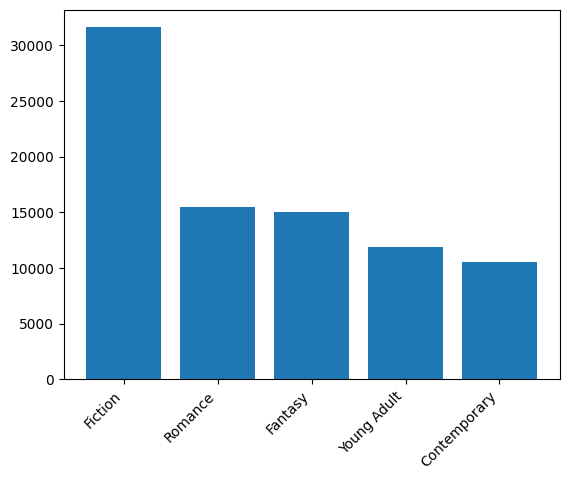

In [13]:
# veo la cantidad de libros publicados pertenecientes a los 5 generos mas populares

plt.bar(x=generos_populares.index, height=generos_populares)
plt.xticks(rotation=45, ha='right')

##### Decada de publicacion ('publishDecade')

In [23]:
df.publishDecade.value_counts()

2010    22531
2000    20261
1990     6095
1980     1883
1970      767
2020      410
1960      291
1950       98
1940       27
1930       24
1920       19
1900        9
1910        5
1880        4
1890        2
2050        1
1870        1
1820        1
Name: publishDecade, dtype: int64

(array([1.0000e+00, 0.0000e+00, 5.0000e+00, 1.6000e+01, 4.3000e+01,
        1.2500e+02, 2.9410e+03, 2.6356e+04, 2.2941e+04, 1.0000e+00]),
 array([1820., 1843., 1866., 1889., 1912., 1935., 1958., 1981., 2004.,
        2027., 2050.]),
 <BarContainer object of 10 artists>)

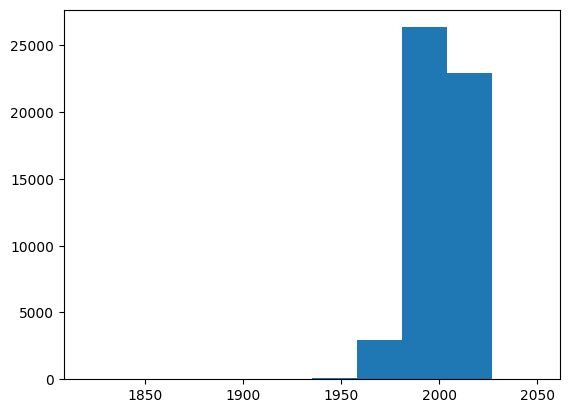

In [22]:
# Hago un histograma de la cantidad de libros publicados en cada decada, aunque como es de esperar por la lista anterior
# Hay 2 decadas que tienen una cantidad muy alta de publicaciones y entonces no se llegan a apreciar el resto de decadas
# que tienen una cantidad mucho menor (o casi nula).

plt.hist(df.publishDecade)

El analisis realizado solo pasa por las variables Autor, Generos y Decada de Publicacion ya que estas son las variables que voy a utilizar para crear el modelo de recomendaciones.
Ademas, no es un analisis muy profundo ya que solo se intentan ver las distribuciones de los componentes principales y ver cuales son las caracteristicas mas repetidas dentro de cada uno porque luego estas serán utilizadas para calcular las relaciones entre cada libro.

### Feature Engineering


Proceso y preparo las variables anteriormente exploradas para su utilizacion en el modelo

In [3]:
# creo una copia del dataframe original
metadata = df.copy()

In [4]:
from ast import literal_eval

features = ['author', 'genres']

metadata['genres'] = metadata['genres'].apply(literal_eval)

In [5]:
# funcion que elimina los espacios, transforma a minuscula y en el caso de strings que contengan una coma, elimina todo el texto a partir de esta.
def cleaner(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", "").split(",")[0])
        else:
            return ''

In [6]:
# limpio las columnas 'author' y 'genres' con la funcion que acabo de crear
for feature in features:
    metadata[f'{feature}Clean'] = metadata[feature].apply(cleaner)

In [7]:
# funcion que devuelve un string concatenando las columnas 'author', 'publishDecade' y 'genres' del dataset utilizado con un espacio.
def make_soup(x):
    return ''.join(x['authorClean']) + ' '  +  ''.join(str(x['publishDecade'])) + ' ' + ' '.join(x['genresClean'])

In [8]:
# guardo la informacion devuelta por la funcion 'make_soup' en una nueva columna 'soup' del dataset
metadata['soup'] = metadata.apply(make_soup, axis=1)

In [9]:
#asi se ven estos resultados
metadata['soup'].head()

0    suzannecollins 2000 youngadult fiction dystopi...
1    j.k.rowling 2000 fantasy youngadult fiction ma...
2    harperlee 2000 classics fiction historicalfict...
3    janeausten 2000 classics fiction romance histo...
4    stepheniemeyer 2000 youngadult fantasy romance...
Name: soup, dtype: object

In [10]:
# Una vez creada la variable soup elimino las variables que no voy a utilizar

metadata.drop(columns=['bookId', 'rating', 'language', 'genres', 'bookFormat', 'pages', 'publishDate', 'firstPublishDate', 'numRatings', 'likedPercent', 'price', 'authorClean', 'genresClean'], inplace=True)

In [11]:
# Creo una variable llamada 'filtro' para usar luego en el filtro de seleccion para el modelo
def make_filtro(metadata):
    return ''.join(metadata['title']) + '-' + ''.join(metadata['author'])

In [12]:
# Limpio la variable 'author' antes de aplicar la funcion creada
# Esto está pensado para eliminar cosas como el termino '(goodreads author)' que aparece al lado del nombre de muchos autores

for i in range(len(metadata)):
    metadata['author'].iloc[i] = metadata['author'].iloc[i].split('(')[0]

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10928\2216697312.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['author'].iloc[i] = metadata['author'].iloc[i].split('(')[0]


In [13]:
# Aplico la funcion creada

metadata['filtro'] = metadata.apply(make_filtro, axis=1)

In [14]:
# Estos son los resultados que se guardaron en la columna filtro

metadata.filtro.head()

0                     The Hunger Games-Suzanne Collins
1    Harry Potter and the Order of the Phoenix-J.K....
2                     To Kill a Mockingbird-Harper Lee
3      Pride and Prejudice-Jane Austen, Anna Quindlen 
4                             Twilight-Stephenie Meyer
Name: filtro, dtype: object

### Creacion del modelo e hypertunning de parametros

In [15]:
# Elimino los libros repetidos y guardo el dataframe como csv
metadata.drop_duplicates(subset=['title'],inplace=True)

metadata.to_csv('metadata.csv')

##### Creacion del Modelo

Como mi modelo utiliza content based filtering, pruebo distintas formas de calcular la similaridad entre los libros solo con la informacion disponible de los mismos.

In [16]:
# creo un vector de relacion usando la columna recien creada
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata['soup'])

In [22]:
count_matrix.shape

(49927, 24645)

In [23]:
# Uso la funcion cosine_similarity para calcular la similaridad entre los vectores de relacion

from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(count_matrix, count_matrix)

In [24]:
# Guardo los resultados en formato pkl

import joblib

joblib.dump(cos_sim, 'cos_sim_model.pkl')

['cos_sim_model.pkl']

In [17]:
# Uso la funcion polynomial kernel para calcular de otra forma la similaridad entre los vectores de relacion

from sklearn.metrics.pairwise import polynomial_kernel

poly_sim = polynomial_kernel(count_matrix, count_matrix)

In [18]:
# guardo los resultados en formato pkl

joblib.dump(poly_sim, 'poly_sim_model.pkl')

['poly_sim_model.pkl']

una vez calculados y guardados los datos de similaridad entre libros creo una forma de utilizarlos para obtener recomendaciones

In [19]:
# reinicio los indices del dataframe metadata y creo una serie con los titulos e id de cada libro para poder relacionar los resultados de las predicciones con dicho dataframe

metadata = metadata.reset_index()
indices = pd.Series(metadata.index, index=metadata['title'])

In [8]:
# creo una funcion que recibe un titulo como input y devuelve los 10 libros mas similares
def get_recommendations(title, scores):
    #encuentro el indice del titulo ingresado
    idx = indices[title]

    #busco los scores de similaridad con este libro
    sim_scores = list(enumerate(scores[idx]))

    #ordeno la lista de libros segun el score obtenido por cada uno
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    #devuelvo los 10 mas similares (salteo el 1ro ya que el libro ingresado es siempre el mas similar a si mismo)
    sim_scores = sim_scores[1:11]

    #busco los indices
    book_indices = [i[0] for i in sim_scores]

    # Devuelvo los titulos y autores de los libros 10 mas similares y el libro ingresado para generarlos
    return pd.DataFrame({'Porque leiste': title,'Titulo': metadata['title'].iloc[book_indices], 'Autor': metadata['author'].iloc[book_indices]})

Con la funcion principal del modelo ya creada, importo los scores de similaridad y creo una funcion para probar con libros aleatorios su funcionamiento.

In [3]:
# Importo los scores de similaridad y el archivo metadata.csv
import joblib
file1 = 'poly_sim_model.pkl'
poly_scores = joblib.load(file1, mmap_mode='r')

file2 = 'cos_sim_model.pkl'
cosine_scores = joblib.load(file2, mmap_mode='r')

metadata = pd.read_csv('metadata.csv')
indices = pd.Series(metadata.index, index=metadata['title'])

In [7]:
def titulos_random():
    #genero 4 numeros aleatorios para usar como indices de libros que luego utilizare para evaluar los resultados

    idx_test = np.random.random_integers(0, len(metadata), 5)

    libros_test = []

    #busco los titulos de los libros que tengan un index de los generados anteriormente y los guardo en una lista
    for idx in idx_test:
        libros_test.append(metadata['title'].iloc[idx])

    return libros_test

In [11]:
# Una vez creada la funcion, genero titulos aleatorios y comparo los resultados en ambos scores
from IPython.display import display_html


libros = titulos_random()


for libro in libros:
    df1 = get_recommendations(libro, cosine_scores)
    df2 = get_recommendations(libro, poly_scores)

    # Se utilizan stylers de html para poder mostrar ambos dataframe lado a lado cuando sea posible
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Cosine Similarity')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Polynomial Kernel')

    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_12132\1048878712.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 49927 + 1) instead
  idx_test = np.random.random_integers(0, len(metadata), 5)


,Porque leiste,Titulo,Autor
39561,Sober Justice,Stain of Guilt,Brandilyn Collins
29816,Sober Justice,Eyes of Justice,Lis Wiehl
30558,Sober Justice,Deadly Loyalty Collection: The Curse/The Undead/The Scream,Bill Myers
13755,Sober Justice,Boneman's Daughters,Ted Dekker
14355,Sober Justice,The Pawn,Steven James
14570,Sober Justice,The Knight,Steven James
26595,Sober Justice,A Table by the Window,Lawana Blackwell
34005,Sober Justice,River's Edge,Terri Blackstock
40290,Sober Justice,Brink of Death,Brandilyn Collins
18425,Sober Justice,John 3:16,Nancy Moser


,Porque leiste,Titulo,Autor
41290,Doctor No,Doctor No,Ian Fleming
9132,Doctor No,Moonraker,Ian Fleming
28647,Doctor No,Goldfinger,Ian Fleming
41571,Doctor No,Live and Let Die,Ian Fleming
41843,Doctor No,Thunderball,Ian Fleming
2524,Doctor No,Casino Royale,Ian Fleming
15523,Doctor No,The Bancroft Strategy,Robert Ludlum
41610,Doctor No,The Man With the Golden Gun,Ian Fleming
45817,Doctor No,De Icarus Intrige,"Robert Ludlum, Frans & Joyce Bruning"
46524,Doctor No,The Hades Factor,"Robert Ludlum, Gayle Lynds"


,Porque leiste,Titulo,Autor
35143,Ink and Bone,The Inventor's Secret,Andrea Cremer
4787,Ink and Bone,Behemoth,Scott Westerfeld
5038,Ink and Bone,Wolf by Wolf,Ryan Graudin
6740,Ink and Bone,Goliath,Scott Westerfeld
9407,Ink and Bone,Masque of the Red Death,Bethany Griffin
11077,Ink and Bone,The Leviathan Trilogy,Scott Westerfeld
11690,Ink and Bone,Everland,Wendy Spinale
11977,Ink and Bone,Kinslayer,Jay Kristoff
18545,Ink and Bone,Stormdancer,Jay Kristoff
23994,Ink and Bone,Endsinger,Jay Kristoff


,Porque leiste,Titulo,Autor
3635,Far from You,"I Heart You, You Haunt Me",Lisa Schroeder
12625,Far from You,Chasing Brooklyn,Lisa Schroeder
40264,Far from You,Must Love Black,Kelly McClymer
12500,Far from You,"Kissing Annabel: Love, Ghosts, and Facial Hair; A Place Like This",Steven Herrick
31862,Far from You,Crank Trilogy,Ellen Hopkins
34972,Far from You,Powers,Deborah Lynn Jacobs
212,Far from You,Fallen,Lauren Kate
615,Far from You,Before I Fall,Lauren Oliver
828,Far from You,Crank,Ellen Hopkins
1222,Far from You,Impulse,Ellen Hopkins


,Porque leiste,Titulo,Autor
23183,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,A Doctor in the House: The Memoirs of Tun Dr Mahathir Mohamad,"Mahathir Mohamad, مهاتير محمد"
1401,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,Long Walk to Freedom,Nelson Mandela
1420,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,I Am Malala: The Story of the Girl Who Stood Up for Education and Was Shot by the Taliban,"Malala Yousafzai, Christina Lamb"
2401,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,The Autobiography of Malcolm X,"Malcolm X, Alex Haley"
4039,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,Stolen Lives: Twenty Years in a Desert Jail,"Malika Oufkir, Michèle Fitoussi"
7460,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,What Happened,Hillary Rodham Clinton
9429,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,In Order to Live: A North Korean Girl's Journey to Freedom,"Yeonmi Park, Maryanne Vollers"
10025,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,"A Higher Loyalty: Truth, Lies, and Leadership",James Comey
10147,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,Hillbilly Elegy: A Memoir of a Family and Culture in Crisis,J.D. Vance
11385,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,The Girl from Aleppo: Nujeen's Escape from War to Freedom,"Nujeen Mustafa, Christina Lamb"


Como se puede observar, las recomendaciones en ambos casos son muy similares, siendo la principal diferencia el orden en el que se presentan los mismos libros.

En el caso de los tiempos de ejecucion y consumo de memoria, es importante destacar que el calculo de el polynomial kernel tardo varios minutos mas en calcularse, pero el cosine similarity ocupa mas espacio en memoria. Aunque todo esto pierde bastante relevancia luego ya que al guardar los calculos en formato pkl no es necesario calcularlos en cada ejecucion de la funcion get_recommendations(), y leyendolos de esta forma ocupan muy poca memoria.

Dicho esto, se llega a la conclusion de que es practicamente indiferente la eleccion del algoritmo de calculo de similaridad. En mi caso, elegi el polynomial kernel ya que analizando los resultados me parecieron mas variados en algunos casos particulares.

En el caso de los metodos de validacion, como este modelo se basa unicamente en las caracteristicas ya conocidas de los libros (llamado content-based filtering) y no tiene una variable objetivo ni datos etiquetados como 'correctos' o 'incorrectos' para realizar las predicciones, la calidad de los resultados es totalmente subjetiva. Por esto, me resulto imposible encontrar un metodo de validacion no manual.

Una vez seleccionado el algoritmo de calculo de similaridad, puedo pasar a la etapa de tunning de hyperparametros.

##### Tunning de Hyperparametros

The effect of the degree of a polynomial kernel. Higher degree polynomial kernels allow a more flexible decision boundary. The style follows that of 3.

In [2]:
metadata = pd.read_csv('metadata.csv')
indices = pd.Series(metadata.index, index=metadata['title'])

In [3]:
# creo un vector de relacion usando la columna recien creada
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata['soup'])

In [4]:
from sklearn.metrics.pairwise import polynomial_kernel

tunned1_poly_sim = polynomial_kernel(count_matrix, count_matrix, degree=15)

In [5]:
import joblib
joblib.dump(tunned1_poly_sim, 'tunned1_poly_sim_model.pkl')

['tunned1_poly_sim_model.pkl']

In [5]:
from sklearn.metrics.pairwise import polynomial_kernel

tunned2_poly_sim = polynomial_kernel(count_matrix, count_matrix, degree=1)

In [6]:
import joblib
joblib.dump(tunned2_poly_sim, 'tunned2_poly_sim_model.pkl')

['tunned2_poly_sim_model.pkl']

In [6]:
# Importo las distintas versiones de mi polynomial kernel

file1 = 'poly_sim_model.pkl'
poly_scores = joblib.load(file1, mmap_mode='r')

file2 = 'tunned1_poly_sim_model.pkl'
tunned1_poly = joblib.load(file2, mmap_mode='r')

file2 = 'tunned2_poly_sim_model.pkl'
tunned2_poly = joblib.load(file2, mmap_mode='r')

metadata = pd.read_csv('metadata.csv')
indices = pd.Series(metadata.index, index=metadata['title'])

In [12]:
# Comparo los resultados de las 3 versiones del polynomial kernel
from IPython.display import display_html

libros = titulos_random()


for libro in libros:
    df1 = get_recommendations(libro, poly_scores)
    df2 = get_recommendations(libro, tunned1_poly)
    df3 = get_recommendations(libro, tunned2_poly)

    # Se utilizan stylers de html para poder mostrar ambos dataframe lado a lado cuando sea posible
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Default Polynomial Kernel')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Degree 15 Polynomial Kernel')
    df3_styler = df3.style.set_table_attributes("style='display:inline'").set_caption('Degree 1 Polynomial Kernel')

    display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_(), raw=True)

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_11232\1048878712.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 49927 + 1) instead
  idx_test = np.random.random_integers(0, len(metadata), 5)


,Porque leiste,Titulo,Autor
481,A Maggot,Snow Falling on Cedars,David Guterson
636,A Maggot,Possession,A.S. Byatt
981,A Maggot,The Collector,John Fowles
1081,A Maggot,Alias Grace,Margaret Atwood
1133,A Maggot,The French Lieutenant's Woman,John Fowles
4358,A Maggot,Wise Children,Angela Carter
5483,A Maggot,Waterland,Graham Swift
7476,A Maggot,A Dance to the Music of Time: 1st Movement,Anthony Powell
10713,A Maggot,A Dance to the Music of Time: 4th Movement,Anthony Powell
10752,A Maggot,A Dance to the Music of Time: 3rd Movement,Anthony Powell


,Porque leiste,Titulo,Autor
15579,The Quilter's Legacy,The Quilter's Apprentice,Jennifer Chiaverini
42857,The Quilter's Legacy,The Sugar Camp Quilt,Jennifer Chiaverini
3237,The Quilter's Legacy,A Woman of Substance,Barbara Taylor Bradford
4005,The Quilter's Legacy,Drowning Ruth,Christina Schwarz
11488,The Quilter's Legacy,Rush Home Road,Lori Lansens
26826,The Quilter's Legacy,Hold the Dream,Barbara Taylor Bradford
40659,The Quilter's Legacy,The Wedding Quilt,Jennifer Chiaverini
30,The Quilter's Legacy,The Help,Kathryn Stockett
44,The Quilter's Legacy,A Thousand Splendid Suns,Khaled Hosseini
55,The Quilter's Legacy,Water for Elephants,Sara Gruen


,Porque leiste,Titulo,Autor
2425,The Republic of Thieves,Red Seas Under Red Skies,Scott Lynch
308,The Republic of Thieves,The Wise Man's Fear,Patrick Rothfuss
342,The Republic of Thieves,The Way of Kings,Brandon Sanderson
635,The Republic of Thieves,Words of Radiance,Brandon Sanderson
669,The Republic of Thieves,The Lies of Locke Lamora,Scott Lynch
1669,The Republic of Thieves,Oathbringer,Brandon Sanderson
1976,The Republic of Thieves,The Black Prism,Brent Weeks
2005,The Republic of Thieves,Blood Song,Anthony Ryan
2371,The Republic of Thieves,Theft of Swords,Michael J. Sullivan
2814,The Republic of Thieves,The Blinding Knife,Brent Weeks


,Porque leiste,Titulo,Autor
36905,Oh-So-Sensible Secretary,What the Bride Didn't Know,Kelly Hunter
41641,Oh-So-Sensible Secretary,The Other Side of Us,Sarah Mayberry
7400,Oh-So-Sensible Secretary,Waking Up Married,Mira Lyn Kelly
11111,Oh-So-Sensible Secretary,When the Right One Comes Along,Kate James
14123,Oh-So-Sensible Secretary,Only Yours,Susan Mallery
14569,Oh-So-Sensible Secretary,Finding Perfect,Susan Mallery
16988,Oh-So-Sensible Secretary,The Heart of Devin MacKade,Nora Roberts
18164,Oh-So-Sensible Secretary,When We Touch,Brenda Novak
18809,Oh-So-Sensible Secretary,Million-Dollar Marriage Merger,Charlene Sands
22699,Oh-So-Sensible Secretary,Sunset in Central Park,Sarah Morgan


,Porque leiste,Titulo,Autor
10195,The Red Garden,The Museum of Extraordinary Things,Alice Hoffman
12085,The Red Garden,Blackbird House,Alice Hoffman
26156,The Red Garden,To The Bright Edge of the World,Eowyn Ivey
2337,The Red Garden,The Snow Child,Eowyn Ivey
2630,The Red Garden,The Dovekeepers,Alice Hoffman
4871,The Red Garden,The Summer that Melted Everything,Tiffany McDaniel
5239,The Red Garden,The Immortalists,Chloe Benjamin
8267,The Red Garden,The Lonely Hearts Hotel,Heather O'Neill
20411,The Red Garden,The Murmur of Bees,Sofía Segovia
24260,The Red Garden,The Incarnations,Susan Barker


Se puede ver en claramente como cambiar los parametros del polynomial kernel no tiene ningun efecto en los resultados del modelo ya que estos son exactamente los mismos en todas las iteraciones del calculo. Por esto, decido quedarme con el polynomial kernel por defecto (que tiene degree=3) para realizar las predicciones.